# **Rocket League Win Prediction Model**
## **Author:** Tanner Rapp
### **Data Source:** Monfret, D. (2022). Rocket League Championship Series 2021-2022 [Dataset]. Kaggle. https://www.kaggle.com/datasets/dylanmonfret/rlcs-202122

### About the Dataset
---

This dataset contains detailed statistics from the Rocket League Championship Series (RLCS) 2021–2022 season. It includes match outcomes, player performance metrics, and in-game events such as goals, assists, possession time, and boost usage. The data provides a rich foundation for analyzing gameplay patterns, predicting match results, and evaluating the key factors that contribute to winning in professional Rocket League competition.


### Import Libraries
---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim


### Load in the Data
---

In [2]:
data = pd.read_csv(r"C:\Users\tanne\OneDrive\Desktop\Fun Statistical Coding Practice\Rocket League\games_by_teams.csv")
print(data.shape)
data.head()

(35594, 55)


,game_id,color,team_id,team_slug,team_name,team_region,ball_possession_time,ball_time_in_side,core_shots,core_goals,...,positioning_time_defensive_third,positioning_time_neutral_third,positioning_time_offensive_third,positioning_time_defensive_half,positioning_time_offensive_half,positioning_time_behind_ball,positioning_time_in_front_ball,demo_inflicted,demo_taken,winner
0,616004f3143c37878b238690,blue,6020bc8ef1e4807cc700391a,https://octane.gg/teams/391a-ground-zero-gaming,GROUND ZERO GAMING,Oceania,136.54,170.84,13,2,...,513.73,291.06,189.48,660.06,334.20,727.07,267.20,1.0,3.0,True
1,616004f3143c37878b238690,orange,614c8930f8090ec745286474,https://octane.gg/teams/6474-ranga-roundup,RANGA ROUNDUP,Oceania,153.60,148.51,4,1,...,457.04,329.25,214.03,633.39,366.93,740.69,259.64,3.0,1.0,False
2,616004f7143c37878b238697,blue,6020bc8ef1e4807cc700391a,https://octane.gg/teams/391a-ground-zero-gaming,GROUND ZERO GAMING,Oceania,155.79,145.60,10,4,...,507.95,308.51,264.92,659.74,421.65,780.01,301.38,5.0,1.0,True
3,616004f7143c37878b238697,orange,614c8930f8090ec745286474,https://octane.gg/teams/6474-ranga-roundup,RANGA ROUNDUP,Oceania,126.81,185.78,6,2,...,561.51,360.96,147.48,762.21,307.73,782.32,287.61,1.0,5.0,False
4,616004fc143c37878b23869e,blue,6020bc8ef1e4807cc700391a,https://octane.gg/teams/391a-ground-zero-gaming,GROUND ZERO GAMING,Oceania,165.76,136.11,11,3,...,476.66,373.66,279.05,648.19,481.20,832.70,296.69,0.0,3.0,True


### Data Prep
---

In [3]:
data.columns

Index(['game_id', 'color', 'team_id', 'team_slug', 'team_name', 'team_region',
       'ball_possession_time', 'ball_time_in_side', 'core_shots', 'core_goals',
       'core_saves', 'core_assists', 'core_score', 'core_shooting_percentage',
       'boost_bpm', 'boost_bcpm', 'boost_avg_amount', 'boost_amount_collected',
       'boost_amount_stolen', 'boost_amount_collected_big',
       'boost_amount_stolen_big', 'boost_amount_collected_small',
       'boost_amount_stolen_small', 'boost_count_collected_big',
       'boost_count_stolen_big', 'boost_count_collected_small',
       'boost_count_stolen_small', 'boost_amount_overfill',
       'boost_amount_overfill_stolen', 'boost_amount_used_while_supersonic',
       'boost_time_zero_boost', 'boost_time_full_boost',
       'boost_time_boost_0_25', 'boost_time_boost_25_50',
       'boost_time_boost_50_75', 'boost_time_boost_75_100',
       'movement_total_distance', 'movement_time_supersonic_speed',
       'movement_time_boost_speed', 'movement_t

In [4]:
# Drop unnecessary variables
data = data.drop(columns=['color','team_slug', 'team_name','team_region'])

In [5]:
# Remove missing values
data = data.dropna()

In [6]:
# Take the average by game_id and team_id (It is a team sport after all)
data = data.groupby(['game_id','team_id'], as_index=False).mean()
data = data.drop(columns=['team_id','game_id'])

In [7]:
# Split into training/test/validation data
x_data = data.drop(columns=['winner'])
y_data = data['winner']

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1)

In [8]:
# Standardize
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test= scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

In [9]:
# Convert to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)
y_val  = torch.tensor(y_val .values,  dtype=torch.float32).view(-1, 1)

### Model Architecture

---

In [11]:
# Define multiple layer model with batch normalization
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, h1, h2):
        super(MLPBinaryClassifier, self).__init__()
        self.Linear1 = nn.Linear(input_dim,h1) 
        self.Linear2 = nn.Linear(h1,h2)
        self.Linear3 = nn.Linear(h2,1) # Binary output 
        self.bn1 = nn.BatchNorm1d(h1)
        self.bn2 = nn.BatchNorm1d(h2)

    def forward(self, x):
        x = self.bn1(torch.relu(self.Linear1(x)))
        x = self.bn2(torch.relu(self.Linear2(x)))
        x = torch.sigmoid(self.Linear3(x))
        return x

input_dim = x_train.shape[1]

model = MLPBinaryClassifier(input_dim, 24, 12)

criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

### Train Model
---

In [12]:
# Define training loop
epochs = 20000

for epoch in range(1, epochs + 1):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 1000 ==0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f}")


# Evaluation phase on test set
model.eval()
with torch.no_grad():
    # Train preds
    train_probs = model(x_train)             # [N,1] in [0,1]
    train_preds = (train_probs >= 0.5).float()
    train_acc = (train_preds.eq(y_train).float().mean().item())

    # Test preds
    test_probs = model(x_test)
    test_preds = (test_probs >= 0.5).float()
    test_acc = (test_preds.eq(y_test).float().mean().item())

     # Validation preds
    val_probs = model(x_val)
    val_preds = (val_probs >= 0.5).float()
    val_acc = (val_preds.eq(y_val).float().mean().item())


print(f"\nTrain Accuracy: {train_acc*100:.2f}%")
print(f"\n    Test Accuracy: {test_acc*100:.2f}%")
print(f"\n          Validation Accuracy: {val_acc*100:.2f}%")
    

Epoch 1000 | Loss: 0.129189
Epoch 2000 | Loss: 0.069898
Epoch 3000 | Loss: 0.045763
Epoch 4000 | Loss: 0.034516
Epoch 5000 | Loss: 0.028498
Epoch 6000 | Loss: 0.026277
Epoch 7000 | Loss: 0.022847
Epoch 8000 | Loss: 0.021349
Epoch 9000 | Loss: 0.020063
Epoch 10000 | Loss: 0.017902
Epoch 11000 | Loss: 0.016245
Epoch 12000 | Loss: 0.015469
Epoch 13000 | Loss: 0.014915
Epoch 14000 | Loss: 0.014216
Epoch 15000 | Loss: 0.013713
Epoch 16000 | Loss: 0.012938
Epoch 17000 | Loss: 0.011858
Epoch 18000 | Loss: 0.011255
Epoch 19000 | Loss: 0.011030
Epoch 20000 | Loss: 0.010296

Train Accuracy: 99.75%

    Test Accuracy: 99.03%

          Validation Accuracy: 98.86%


### Visualize Performance
---

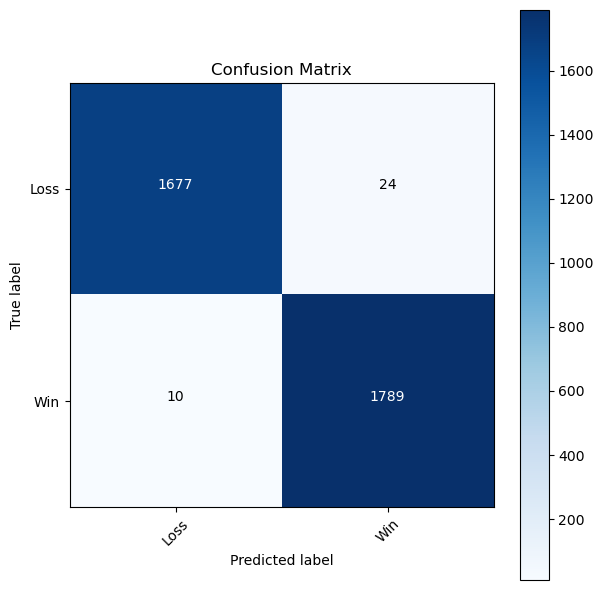

Classification Report:
               precision    recall  f1-score   support

        Loss       0.99      0.99      0.99      1701
         Win       0.99      0.99      0.99      1799

    accuracy                           0.99      3500
   macro avg       0.99      0.99      0.99      3500
weighted avg       0.99      0.99      0.99      3500



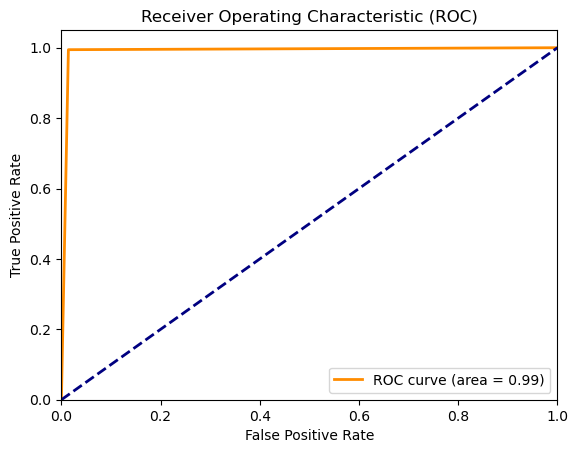

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Visualize the confusion matrix
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, test_preds, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


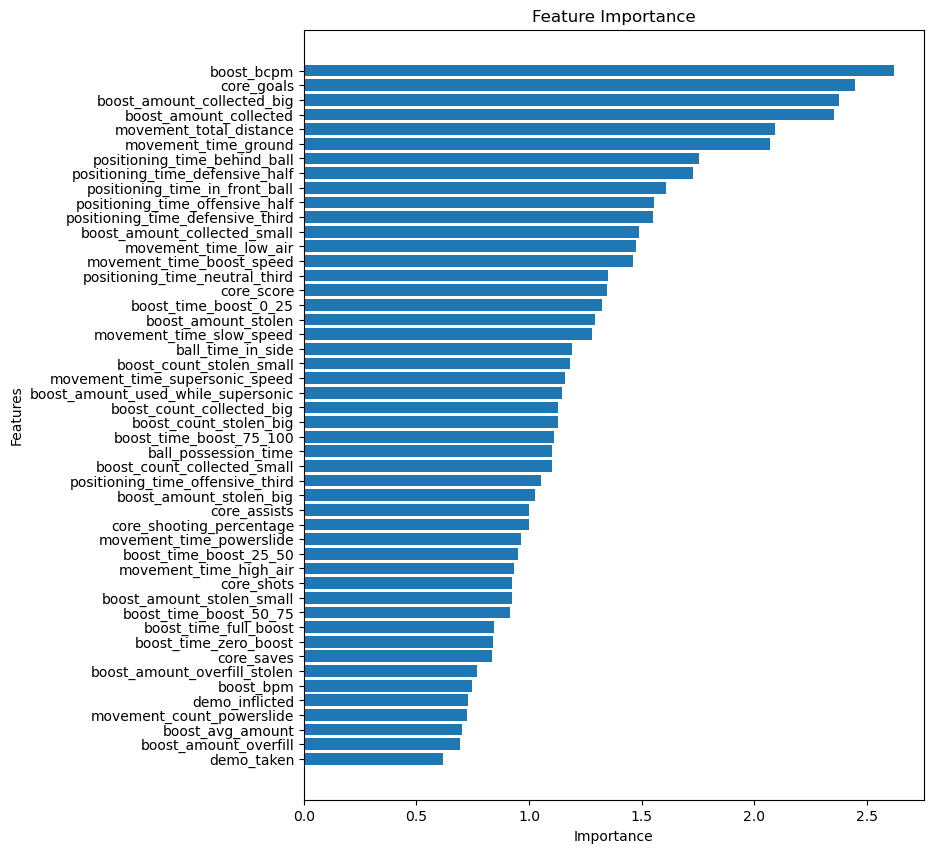

In [14]:
with torch.no_grad():
    W1 = model.Linear1.weight.data.abs()   # (24, 48)
    W2 = model.Linear2.weight.data.abs()   # (12, 24)
    W3 = model.Linear3.weight.data.abs()   # (1, 12)

    # Path strengths from inputs -> hidden1 -> hidden2 -> output
    # (12,24)@(24,48)->(12,48); (1,12)@(12,48)->(1,48)
    scores = (W3 @ (W2 @ W1)).squeeze(0).cpu().numpy()

features_df = (pd.DataFrame({
                    "Feature": x_data.columns,
                    "Importance": scores})
                 .sort_values(by="Importance", ascending=False))


# Plot 
plt.figure(figsize=(8, 10))  
plt.barh(features_df['Feature'], features_df['Importance'])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()


### Summary
---

This model demonstrates excellent performance on the Rocket League dataset.  

- Confusion Matrix: The confusion matrix shows very few misclassifications (24 false positives and 10 false negatives) out of 3,500 matches.

- Classification Report: Precision, recall, and F1-score are all at 0.99 for both “Loss” and “Win,” indicating balanced performance across classes.

- ROC Curve (AUC = 0.99): The ROC curve confirms that the model is highly effective at distinguishing between the two outcomes, with near-perfect separability. 

The above plot shows the feature importance values from a Rocket League dataset I analyzed. Positive weights (to the right) indicate features that push predictions toward winning, while negative weights (to the left) are more associated with losing. Goals, score, ball possession, and shooting percentage stand out as the strongest predictors of winning outcomes, while defensive positioning and time spent away from the ball lean toward losses. Overall, it highlights which gameplay metrics matter most for predicting match results.

The most influential variables are **boost efficiency (boost_bcpm)**, **goals scored (core_goals)**, and **boost collection metrics** (e.g., boost_amount_collected_big). These features contribute the most to the model’s predictions, highlighting the strong role of resource management and scoring performance in determining match results. Lower-ranked features such as **demo_taken**, **boost_overfill**, and **powerslide counts** have much less predictive power, suggesting they are less critical for outcome prediction.  

Overall, the analysis confirms that **scoring ability and efficient boost usage are the strongest determinants of winning or losing**.
